In [1]:
""" 

TASK 4

Climatologia: Confronto tra storico e osservato sul campo delle SST tra il modello e l'osservato
<SST_modello>(mediato sugli ultimi 30 anni) - <SST_obs>(mediato sugli ultimi 30 anni)
---> in questo modo vediamo eventuali discrepanze del modello.
"""

" \n\nTASK 4\n\nClimatologia: Confronto tra storico e osservato sul campo delle SST tra il modello e l'osservato\n<SST_modello>(mediato sugli ultimi 30 anni) - <SST_obs>(mediato sugli ultimi 30 anni)\n---> in questo modo vediamo eventuali discrepanze del modello.\n"

In [1]:
# import libraries
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import climtools_lib as ctl


No DISPLAY variable set. Switching to agg backend


In [2]:
#Comando che rende le immagini generate visualizzabili
%matplotlib inline

In [3]:
#Acquisizione dei dati
Dir_SSTOBS='/nas/reference/HadISST/2020/HadISST_sst.nc' # Osservato
Dir_SST = '/nas/BOTTINO/CMIP6/LongRunMIP/EC-Earth-Consortium/EC-Earth3/historical/r4i1p1f1/Omon/tos_rg_1850-2014.nc' # Modello storico
Dir_output = '/home/montanarini/output/'
Dir_images = '/home/montanarini/images/task4-climatology/'

OBS = xr.open_dataset(Dir_SSTOBS)
Model=xr.open_dataset(Dir_SST)

""" 
Coordinate modello
lon: 0-->360
lat: -90-->90
coordinate osservato
lon: -180(W)-->180(E)
lat: 90-->-90
"""

#Regridding
OBS = ctl.regrid_dataset(OBS, regrid_to_reference=Model)

#Estrazione DataArray dai DataSet
SSTOBS = OBS['sst']
SSTModel = Model['tos']

#SSTOBS = SSTOBS.rename({'longitude':'lon', 'latitude':'lat'}) #In caso non si fosse fatto il regridding

# # Estrazione coordinate dai DataSet
# timeO = OBS['time'].to_numpy();
# lonO = OBS['longitude'].to_numpy();
# latO = OBS['latitude'].to_numpy();
# timeM = Model['time'].to_numpy();
# lonM = Model['lon'].to_numpy();
# latM = Model['lat'].to_numpy();

Regridding...
Regridding completed in 0:00:06.697848


In [5]:
print(Model.info(), '\n', Model.data_vars,'\n')
print('\n', OBS.info(), '\n', OBS.data_vars)

xarray.Dataset {
dimensions:
	time = 1980 ;
	lat = 180 ;
	lon = 360 ;

variables:
	float32 tos(time, lat, lon) ;
	datetime64[ns] time(time) ;
	float64 lon(lon) ;
	float64 lat(lat) ;

// global attributes:
	:regrid_method = bilinear ;
}None 
 Data variables:
    tos      (time, lat, lon) float32 ... 

xarray.Dataset {
dimensions:
	time = 1811 ;
	lat = 180 ;
	lon = 360 ;

variables:
	float32 sst(time, lat, lon) ;
	datetime64[ns] time(time) ;
	float64 lon(lon) ;
	float64 lat(lat) ;

// global attributes:
	:regrid_method = bilinear ;
}
 None 
 Data variables:
    sst      (time, lat, lon) float32 nan nan nan nan ... -1.8 -1.8 -1.8 -1.8


In [4]:
SSTOBS = SSTOBS.sel(lat=slice(-85,85))
SSTModel = SSTModel.sel(lat=slice(-85,85))

# Estrazione coordinate dai DataArray
time = SSTOBS['time']
lon = SSTOBS['lon']
lat = SSTOBS['lat']
# Calcolo della Climatologia
   #Il range della climatologia è: '1983-12-31'<-->'2014-12-31' perchè il 2014 è la data ultima a cui arriva il dataset dello storico
SSTOBS_clim = SSTOBS.sel(time=slice('1983-12-31', '2014-12-31')).mean("time").compute()
SSTModel_clim = SSTModel.sel(time=slice('1983-12-31', '2014-12-31')).mean("time").compute()
#SSTModel_climM = SSTModel.sel(time=slice('1983-12-31', '2014-12-31')).groupby("time.month").mean("time").mean("month").compute() #Variante di selezione totalmente equivalente

####################################Maschera per valori anomali del dataset dell'osservato####################################
SSTOBS_clim = xr.where(SSTOBS_clim < 2, np.nan, SSTOBS_clim)

discrepance = SSTModel_clim - SSTOBS_clim


#Box nel pacifico per Ninõ
las, lan=-5, 5
low, loe=190, 240
# Create a figure with Equidist-Cylindrical proj.
proj0 = ccrs.PlateCarree()
proj=ccrs.PlateCarree(central_longitude=205)

In [7]:
np.nanmin(discrepance), np.nanmax(discrepance) 

(-6.232787, 7.1727934)

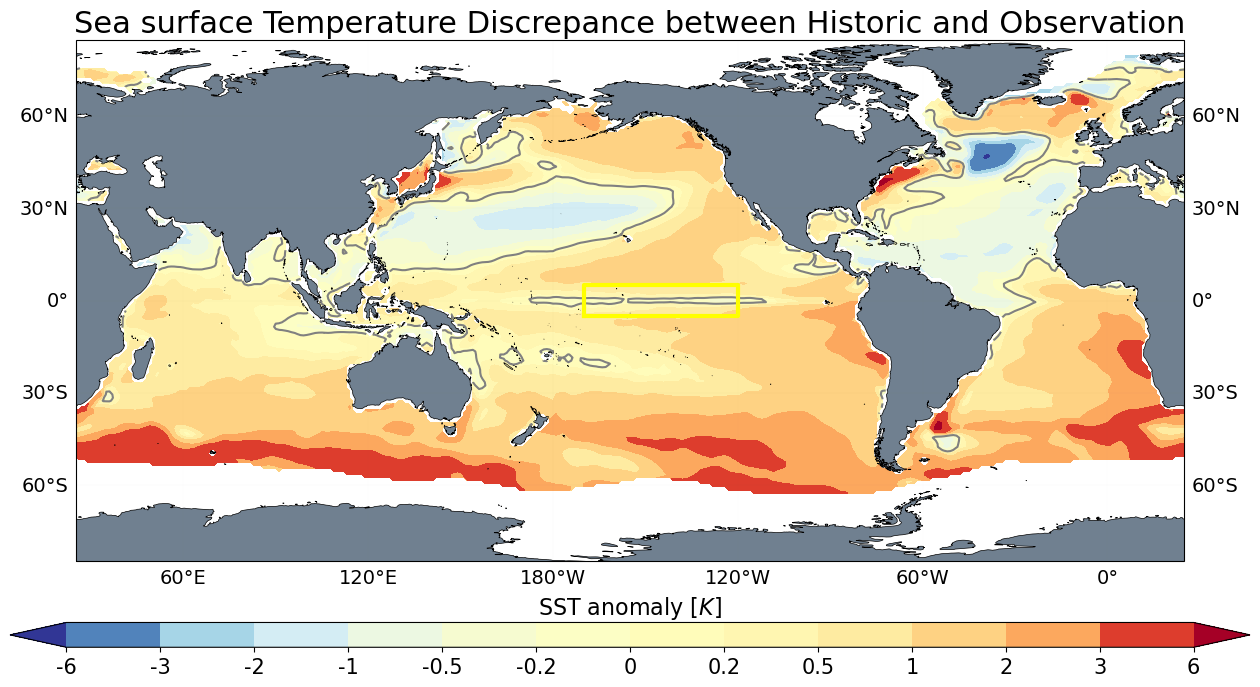

In [5]:
################################################################################################
######################### Hystoric - Observed Climatology ######################################
################################################################################################
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16, 8))
# levels of plot
# levelsSX = np.geomspace(-6, -1, num=5, endpoint=True, dtype=int)
# levelsDX = np.geomspace(1, 6, num=5, endpoint=True, dtype=int)
# #levels=np.round(levels, 2)
# levels = np.concatenate((levelsSX, levelsDX))
# levels = np.delete(levels, [4,5])
# levels = np.insert(levels, 4, 0)
levels = [-6,-3,-2,-1,-0.5,-0.2,0,0.2,0.5,1,2,3,6]
# Adds coastlines to the current axes
res = '50m'
ax.coastlines(resolution=res, linewidths=0.5)
# Hide white longitude line
lon_o = lon.copy() #originale
discrepance, lon_o = cutil.add_cyclic_point(discrepance, coord = lon_o)
# Turn on continent shading
ax.add_feature(cfeature.LAND.with_scale(res), facecolor='slategray')
#ax.add_feature(cart.feature.LAND, zorder=100, facecolor='slategray', edgecolor='k')
# Contourf-plot data
scalarf = ax.contourf(lon_o, lat, discrepance, cmap='RdYlBu_r', transform=proj0,
                     levels=levels, extend='both') #'coolwarm'
scalar = ax.contour(lon_o, lat, discrepance, colors = 'gray', transform=proj0, levels=[0])
#scalar.set_clim(-6,6)
# Set a title for the axes.
#plt.suptitle('Ninõ Index regression over Sea Surface Temperature', fontsize=16) #
ax.set_title('Sea surface Temperature Discrepance between Historic and Observation', fontsize=22)
# Add color bar
cbar = plt.colorbar(scalarf, ax=ax, ticks=levels, orientation='horizontal', aspect=50, fraction=0.055, pad=0.1)
cbar.set_ticklabels(['-6','-3','-2','-1','-0.5','-0.2','0','0.2','0.5','1','2','3','6'])
cbar.ax.set_title('SST anomaly ' r'$[K]$', fontsize=16) 
#Ninō 3.4 Box
x=[low, loe, loe, low, low]
y=[las, las, lan, lan, las]
ax.plot(x, y, color='yellow', linewidth=3, transform=proj0)
#ax.text(-3, 0, 'Ninō3.4 Box', style='italic', color='k', fontsize=10) # -155, 0
#set axis thick labels
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels = True
gl.bottom_labels =False
gl.top_labels = False
gl.right_labels = True
gl.xlines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
# 2° ripetizione in cui si cambia il 'crs' per poter disegnare le labels sulla destra del plot
gl = ax.gridlines(crs=proj0, draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')
gl.left_labels =False
gl.bottom_labels =True
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
#plt.tight_layout()
# Save the current figure to a file
fig.savefig(Dir_images+'ModelDiscrepanceFromObserved.pdf', bbox_inches='tight')
fig.savefig(Dir_images+'ModelDiscrepanceFromObserved.jpg', bbox_inches='tight', dpi=150)
# Display the figure
plt.show()